In [1]:
from netCDF4 import Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from sensor_helper import *
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, confusion_matrix, r2_score
from sklearn.model_selection import TimeSeriesSplit, KFold
from sklearn.pipeline import make_pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegressionCV, RidgeCV, LogisticRegression
from sklearn.preprocessing import RobustScaler
from tqdm import tqdm
%load_ext autoreload
%autoreload 2

In [226]:
def put_gnb_on_grid(grid, clf_list, gnb_idx=0):
    grid_clf = np.zeros(grid.shape)
    for gg, clf in zip(np.unique(grid), clf_list):
        grid_clf[grid==gg] = clf.named_steps['gaussiannb'].theta_[gnb_idx]
    
    return grid_clf


def put_lda_on_grid(grid, clf_list):
    grid_clf = np.zeros(grid.shape)
    for gg, clf in zip(np.unique(grid), clf_list):
        grid_clf[grid==gg] = clf.named_steps['lineardiscriminantanalysis'].coef_[0]
    
    return grid_clf


def preprocess_data_grid(data, grid, len_lat=96, len_lon=192):
    '''
    Keep in mind that grid indicates which features correspond to which 
    classifier. If reshaping data, the grid needs to be changed accordingly.
    '''
    data_flat = np.array(data.reshape(-1, len_lat * len_lon))
    grid_flat = grid.reshape(-1)
    
    return data_flat, grid_flat


def put_scores_on_grid(grid, scores):
    grid_clf = np.zeros(grid.shape)
    for gg, sc in zip(np.unique(grid), scores):
        grid_clf[grid==gg] = sc
    
    return grid_clf


# Prepare hold_out data
def score_on_hold_out(X, y, final_clfs, grid, len_lat=96, len_lon=192, 
                      metric=roc_auc_score, scores_index=None, proba=True):

    X = load_simulation(X)[0]
    X, grid = preprocess_data_grid(X, grid)

    predictions = predict_on_grid(X, y, final_clfs, grid, proba=proba)

    scores = score_on_grid(y, predictions, metric)
    if scores_index is not None:
        avg_pred =  predictions[:, scores_index].mean(1)
    else:
        avg_pred = predictions.mean(1)
    
    score_avg = metric(y, avg_pred)
    
    return predictions, scores, avg_pred, score_avg



def run_grid_classification(X, y, grid, cv, clf, metric=roc_auc_score, proba=True, best_vals=False):
    X = load_simulation(X)[0]
    X, grid = preprocess_data_grid(X, grid)
    
    predictions = np.zeros((y.shape[0], np.unique(grid).shape[0]))
    scores = np.zeros((TSS.n_splits, np.unique(grid).shape[0]))
    clf_list = []

    for train_index, test_index in tqdm(TSS.split(X)):

        cv_clf_list = []

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        curr_clf = fit_on_grid(X_train, y_train, clf, grid)

        predictions[test_index, :] = predict_on_grid(X_test, y_test, curr_clf, grid, proba=proba)

        clf_list.append(curr_clf)

    scores = score_on_grid(y[np.int(X.shape[0] / n_splits) : ],
                           predictions[np.int(X.shape[0] / n_splits):, :], metric)

    # Select best grids:
    scores_idx = scores > np.percentile(scores, 75)
    
    if not best_vals:
        avg_pred = np.mean(predictions[:, scores_idx], 1)
    else:
        avg_pred = np.mean(predictions, 1)
        
    print("Average Score")
    print(metric(y, avg_pred))
    ## After cross-validation fit on all data:
    final_clfs = fit_on_grid(X, y, clf, grid)
    
    return final_clfs, clf_list, scores, predictions, scores_idx


def plot_map_with_cbar(data, lon, lat):
    fig, axes = plt.subplots(1, 1, figsize=(15, 5), subplot_kw={'projection': ccrs.PlateCarree()})
    axes.set_global()
    axes.coastlines()
    im = axes.contourf(lon, lat, data,transform=ccrs.PlateCarree(), cmap='coolwarm') 
    cax = fig.add_axes([0.26, 0.0, 0.51, 0.05])

    fig.colorbar(im, cax=cax, orientation='horizontal')
    
    return fig, axes


def permutation_test(y_true, y_pred, scorer, greater_is_better=True, n_perms=100):
    '''
    Does a permutation test. 
    '''
    score = scorer(y_true, y_pred)
    # Permutations:
    perms = np.zeros(n_perms)
    
    for ii in range(n_perms): 
        perms[ii] = scorer(y_true, 
                           np.random.choice(y_pred, size=y_pred.shape, 
                                            replace=False))
    
    if greater_is_better:
        pval = (np.sum(perms > score) + 1) / (n_perms + 1)
    else:
        pval = (np.sum(perms < score) + 1) / (n_perms + 1)

    return score, pval, perms


def sig_on_grid(y, y_pred, metric):
    '''
    Calculates a score for each prediction of a grid classifier.
    '''
    scores = np.zeros((y_pred.shape[1], 2))
    for ii in range(y_pred.shape[1]):
        tmp=  permutation_test(y, y_pred[:, ii], metric)
        scores[ii, 0] = tmp[0] 
        scores[ii, 1] = tmp[1]
        
    return scores

In [3]:
data, lat, lon = load_simulation('R1')
# Store the lenght
len_lat = lat.shape[0]
len_lon = lon.shape[0]
VOL =  Dataset('data/Volc_Forc_AOD_1st_mill.nc', 'r')['AOD'][:, 0, 0]
SUN =  Dataset('data/Solar_forcing_1st_mill.nc', 'r')['TSI'][:, 0, 0]

## Sensor array subdivides map into squares
The idea is to subdivide our map into sub areas and train a classifier on each sub area. 

In [49]:
sensor_grid = sensor_fields(len_lat, len_lon, 6, 6)

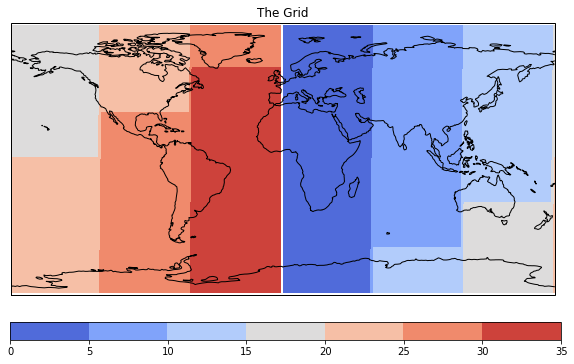

In [181]:
fig, axes = plt.subplots(1, 1, figsize=(15, 5), subplot_kw={'projection': ccrs.PlateCarree()})
axes.set_global()
axes.coastlines()
im = axes.contourf(lon, lat, sensor_grid,transform=ccrs.PlateCarree(), cmap='coolwarm') 
cax = fig.add_axes([0.26, 0.0, 0.51, 0.05])
fig.colorbar(im, cax=cax, orientation='horizontal')
axes.set_title('The Grid')
plt.savefig('correlation_plots/grid_design.png', transparent=True, bbox_inches='tight')

In [50]:
# Really hacky but it might do the trick
SUN_min = pd.DataFrame(SUN, columns=['SUN'])['SUN'].rolling(window=11,center=True,min_periods=1).min().values
VOL_max = pd.DataFrame(VOL, columns=['VOL'])['VOL'].rolling(window=11,center=True,min_periods=1).max().values
# Featurize SUN time:
SUN_class = SUN == SUN_min
VOL_class = np.logical_and(VOL == VOL_max, VOL_max != 0)

[(0, 1)]

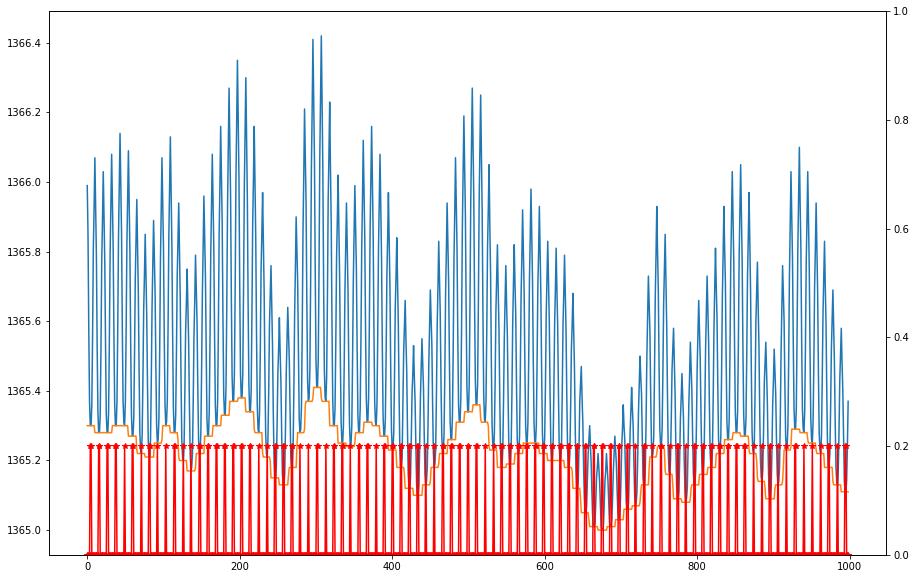

In [113]:
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(SUN)
ax.plot(SUN_min)
ax2 = ax.twinx() 
ax2.plot(SUN_class * 0.2, '-*',  color='r')
ax2.set(ylim = [0, 1])

[(0, 1)]

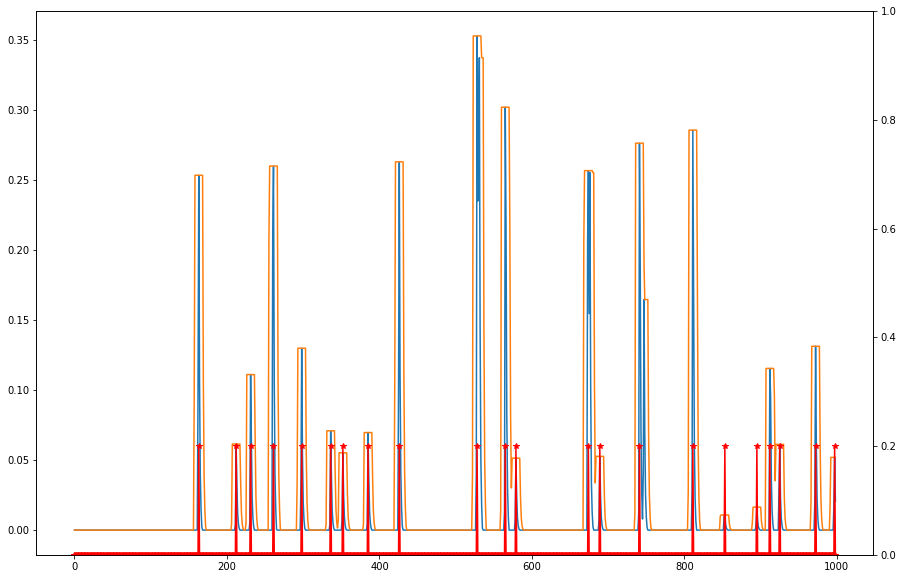

In [115]:
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(VOL)
ax.plot(VOL_max)
ax2 = ax.twinx() 
ax2.plot(VOL_class * 0.2, '-*',  color='r')
ax2.set(ylim = [0, 1])

In [207]:
# Cross validation - split data:
# Splitting the data into 4s
from sklearn.svm import SVC


n_splits = 3
TSS = TimeSeriesSplit(n_splits=n_splits)

y = SUN_class
cv = TSS
clf = make_pipeline(PCA(n_components=10), GaussianNB())

In [208]:
final_clfs, _, scores_cv, predictions_cv, sc_idx = run_grid_classification('R1', y, sensor_grid, cv, clf, 
                                                         proba=True, metric=roc_auc_score);\

predictions, scores = score_on_hold_out('R2', y, final_clfs, sensor_grid, proba=True, 
                           metric=roc_auc_score, scores_index=sc_idx)[:2]

# Significant?
sig_sc1 = sig_on_grid(y[np.int(999/ n_splits):], predictions_cv[np.int(999/ n_splits):], metric=roc_auc_score)
sig_sc2 = sig_on_grid(y, predictions_cv, metric=roc_auc_score)

4it [00:01,  3.81it/s]


Average Score
0.5537400145243283


Text(0.5, 1.0, 'Cross-Validation Score (roc/auc)\n roc_auc_avg:0.54')

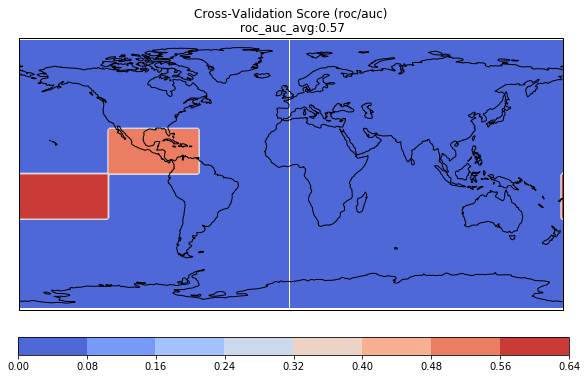

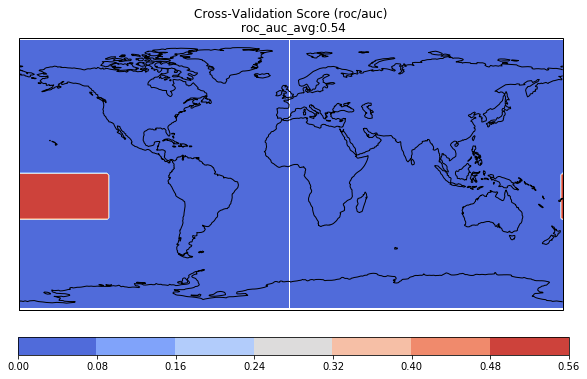

In [231]:
sc_filt1 = sig_sc1[:, 0] * (sig_sc1[:, 1] < 0.05) 
sc_filt2 = sig_sc2[:, 0] * (sig_sc2[:, 1] < 0.05) 

sc1 = put_scores_on_grid(sensor_grid, sc_filt1)
sc2 = put_scores_on_grid(sensor_grid, sc_filt2)

fig, axes = plot_map_with_cbar(sc1, lon, lat)
axes.set_title(f'Cross-Validation Score (roc/auc)\n roc_auc_avg:{np.mean(sc_filt1[sc_filt1!=0]):4.2f}')
plt.savefig('correlation_plots/gnb_cv_r1.png', transparent=True, bbox_inches='tight')

fig, axes = plot_map_with_cbar(sc2, lon, lat)
axes.set_title(f'Score on Holdout (roc/auc)\n roc_auc_avg:{np.mean(sc_filt2[sc_filt2!=0]):4.2f}')
plt.savefig('correlation_plots/gnb_ho_r2.png', transparent=True, bbox_inches='tight')


3it [00:00,  3.98it/s]


Average Score
0.5250621919374526


(<Figure size 1080x360 with 2 Axes>,
 array([<cartopy.mpl.geoaxes.GeoAxesSubplot object at 0x7fa6302d9590>,
       dtype=object))

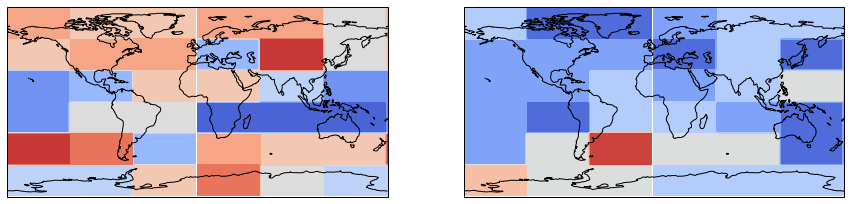

In [118]:
final_clfs, _, scores_cv, predictions_cv, sc_idx = run_grid_classification('R2', y, sensor_grid, cv, clf, 
                                                         proba=True, metric=roc_auc_score);\

predictions, scores = score_on_hold_out('R1', y, final_clfs, sensor_grid, proba=True, 
                           metric=roc_auc_score, scores_index=sc_idx)[:2]

# Significant?
sig_sc1 = sig_on_grid(y[np.int(999/ n_splits):], predictions_cv[np.int(999/ n_splits):], metric=roc_auc_score)
sig_sc2 = sig_on_grid(y, predictions_cv, metric=roc_auc_score)


In [ ]:
sc_filt1 = sig_sc1[:, 0] * (sig_sc1[:, 1] < 0.05) 
sc_filt2 = sig_sc2[:, 0] * (sig_sc2[:, 1] < 0.05) 

sc1 = put_scores_on_grid(sensor_grid, sc_filt1)
sc2 = put_scores_on_grid(sensor_grid, sc_filt2)

fig, axes = plot_map_with_cbar(sc1, lon, lat)
axes.set_title(f'Cross-Validation Score (roc/auc)\n roc_auc_avg:{np.mean(sc_filt1[sc_filt1!=0]):4.2f}')
plt.savefig('correlation_plots/gnb_cv_r2.png', transparent=True, bbox_inches='tight')

fig, axes = plot_map_with_cbar(sc2, lon, lat)
axes.set_title(f'Score on Holdout (roc/auc)\n roc_auc_avg:{np.mean(sc_filt2[sc_filt2!=0]):4.2f}')
plt.savefig('correlation_plots/gnb_ho_r1.png', transparent=True, bbox_inches='tight')